### Import all the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import expit
from scipy.special import softmax as smax

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time

from keras.utils.np_utils import to_categorical

%matplotlib inline

Using TensorFlow backend.


### Fetch the MNIST dataset from sklearn datasets module

In [8]:
data_set = datasets.fetch_openml("mnist_784", version=1, return_X_y = True)
pixel_values, targets = data_set

### Visualiszing the first digit

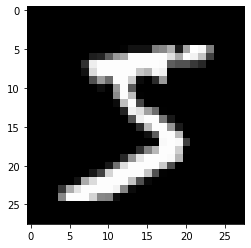

True Label associated with it = 5


In [9]:
#visualizing one single digit
single_digit = pixel_values[0,:].reshape(28,28)
plt.imshow(single_digit, cmap='gray')
plt.show()
#the corresponing true label
print("True Label associated with it =",targets[0])

### Preprocessing the dataset

In [29]:
#since targets are of string type, we convert them into integers
y_int = targets.astype(int)
#now converting to one hot encoded arrays
y = to_categorical(y_int)

#normalize  and convert type to float 32
x = (pixel_values/255)
print(x.shape)
print(y.shape)


(70000, 784)
(70000, 10)


### splitting into training, validation, and testing data

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.06, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.08, random_state=42)

#reshaping
x_train = x_train.T
x_test = x_test.T
x_val = x_val.T
y_train = y_train.T
y_test = y_test.T
y_val = y_val.T


print("X train shape",x_train.shape)
print("Y train shape",y_train.shape)
print("X val shape",x_val.shape)
print("Y val shape",y_val.shape)
print("X test shape",x_test.shape)
print("Y test shape",y_test.shape)

X train shape (784, 60536)
Y train shape (10, 60536)
X val shape (784, 5264)
Y val shape (10, 5264)
X test shape (784, 4200)
Y test shape (10, 4200)


### Creating a Deep Neural Network class

In [66]:
class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=1000, l_rate=0.5):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer1=self.sizes[1]
        hidden_layer2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            "W1" : np.random.randn(hidden_layer1, input_layer),
            "W2" : np.random.randn(hidden_layer2, hidden_layer1),
            "W3" : np.random.randn(output_layer, hidden_layer2),#*np.sqrt(1. / output_layer),
            "B1" : np.zeros((hidden_layer1,1), np.float32),
            "B2" : np.zeros((hidden_layer2,1), np.float32),
            "B3" : np.zeros((output_layer,1), np.float32),
        }

        return params
    
    def compute_loss(self, y, y_hat):
        L_sum = np.sum(np.multiply(y, np.log(y_hat)))
        m = y.shape[1]
        L = -(1./m) * L_sum
        return L
    
    def sigmoid(self, x, derivative=False):
        #using the expit function from scipy
        if derivative:
            return  (self.sigmoid(x,False))*(1 - self.sigmoid(x,False))
        return expit(x)
    
    def tanh(self, x, derivative=False):
        if derivative:
            tanh_x = self.tanh(x)
            return (1-tanh_x*tanh_x)
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def softmax(self, x):
        return smax(x, axis=0)
        #return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    def forward_pass(self, x_train):
        params = self.params
        
        #for layer 1 to l-1, i.e., till one but last layer, get the outputs
        #h0 is the input itself
        params["H0"] = x_train
        
        # input layer to hidden layer 1
        params["A1"] = np.matmul(params["W1"], params["H0"]) + params["B1"]
        params["H1"] = self.sigmoid(params["A1"])

        # hidden layer 1 to hidden layer 2
        params["A2"] = np.matmul(params["W2"], params["H1"]) + params["B2"]
        params["H2"] = self.sigmoid(params["A2"])

        # hidden layer 2 to output layer
        params["A3"] = np.matmul(params["W3"], params["H2"]) + params["B3"]
        params["H3"] = self.softmax(params["A3"])
                
        #return the predicted out that is H3
        return params["H3"]
    
    def backward_pass(self, y_train, output):
        
        #Back Propagation to learn the weights and biases
        #we will get the output from the forward pass
        params = self.params
        change_w = {}
        n_samples = y_train.shape[1]
        
        # Calculate W3 update
        error = output - y_train
        change_w['W3'] = (1./n_samples) * np.matmul(error, params["H2"].T)
        change_w['B3'] = (1./n_samples) * np.sum(error,axis=1, keepdims=True)

        # Calculate W2 update
        # hadamard operation between : [compute the graients wrt to the layer below],[derivative of activation function]
        error = np.multiply(np.matmul(params["W3"].T,error), self.sigmoid(params["A2"], derivative=True))
        change_w['W2'] = (1./n_samples) * np.matmul(error, params["H1"].T)
        change_w['B2'] = (1./n_samples) * np.sum(error,axis=1, keepdims=True)

        # Calculate W1 update
        # hadamard operation between : [compute the graients wrt to the layer below],[derivative of activation function]
        error = np.multiply(np.matmul(params["W2"].T,error), self.sigmoid(params["A1"], derivative=True))
        change_w['W1'] = (1./n_samples) * np.matmul(error, params["H0"].T)
        change_w['B1'] = (1./n_samples) * np.sum(error,axis=1, keepdims=True)
        
        return change_w
    
    def update_network_parameters(self, changes_to_w):
        #Update network parameters according to update rule from Stochastic Gradient Descent.
        #θ = θ - η * ∇J(x, y)
        
        for key, value in changes_to_w.items():
            self.params[key] = self.params[key] - (self.l_rate * value)
            
    def compute_accuracy(self, x_val, y_val):
        output = self.forward_pass(x_val)
        pred = np.argmax(output,axis=0)
        actual = np.argmax(y_val,axis=0)
        predictions = (actual == pred)
        return np.average(predictions)
    
    def train(self, x_train, y_train, x_val, y_val):
        for iteration in range(self.epochs):
            start_time = time.time()
            
            output = self.forward_pass(x_train)
            train_cost = self.compute_loss(y_train, output)
            
            changes_to_w = self.backward_pass(y_train, output)
            
            #update after one pass over the entire dataset
            self.update_network_parameters(changes_to_w)
            
            val_ouput = self.forward_pass(x_val)
            val_cost = self.compute_loss(y_val, val_ouput)
            print("Epoch {}: Training cost = {}, Validation cost = {}".format(iteration+1 ,train_cost, val_cost))


In [67]:
#training and validating
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(x_train, y_train, x_val, y_val)

Epoch 1: Training cost = 9.115096532702324, Validation cost = 5.938875386188346
Epoch 2: Training cost = 5.857774568220931, Validation cost = 4.525648219549174
Epoch 3: Training cost = 4.520614861413305, Validation cost = 3.774295931396105
Epoch 4: Training cost = 3.770279069628081, Validation cost = 3.4373534492438718
Epoch 5: Training cost = 3.4441947439364298, Validation cost = 3.252708864706441
Epoch 6: Training cost = 3.2654951977965605, Validation cost = 3.100814554951201
Epoch 7: Training cost = 3.114896849404494, Validation cost = 2.9678133053777143
Epoch 8: Training cost = 2.982625241674445, Validation cost = 2.851032248858405
Epoch 9: Training cost = 2.865927147111976, Validation cost = 2.7479804676210664
Epoch 10: Training cost = 2.7624514536837608, Validation cost = 2.656417353372809
Epoch 11: Training cost = 2.6701357268097876, Validation cost = 2.5744250818722785
Epoch 12: Training cost = 2.5872077068585217, Validation cost = 2.5003972213729053
Epoch 13: Training cost = 2

Epoch 101: Training cost = 1.0682565090145102, Validation cost = 1.076353541267268
Epoch 102: Training cost = 1.0639394969736584, Validation cost = 1.0721872347554573
Epoch 103: Training cost = 1.059683739660261, Validation cost = 1.0680794098706445
Epoch 104: Training cost = 1.0554877329384214, Validation cost = 1.0640287078202129
Epoch 105: Training cost = 1.0513500227643746, Validation cost = 1.060033813772789
Epoch 106: Training cost = 1.047269203093672, Validation cost = 1.0560934548701075
Epoch 107: Training cost = 1.0432439138992657, Validation cost = 1.0522063983598222
Epoch 108: Training cost = 1.0392728392929458, Validation cost = 1.0483714498408485
Epoch 109: Training cost = 1.0353547057432757, Validation cost = 1.044587451613426
Epoch 110: Training cost = 1.0314882803836327, Validation cost = 1.0408532811266447
Epoch 111: Training cost = 1.0276723694045473, Validation cost = 1.0371678495166754
Epoch 112: Training cost = 1.0239058165249302, Validation cost = 1.03353010022942

Epoch 199: Training cost = 0.8092183548592552, Validation cost = 0.8278008059027482
Epoch 200: Training cost = 0.8075443197054635, Validation cost = 0.8262144766523053
Epoch 201: Training cost = 0.8058816397242127, Validation cost = 0.8246390834324628
Epoch 202: Training cost = 0.8042301818845177, Validation cost = 0.8230744888857675
Epoch 203: Training cost = 0.8025898154849707, Validation cost = 0.8215205580813447
Epoch 204: Training cost = 0.8009604120991565, Validation cost = 0.8199771584647619
Epoch 205: Training cost = 0.7993418455225937, Validation cost = 0.8184441598092005
Epoch 206: Training cost = 0.7977339917211264, Validation cost = 0.8169214341678886
Epoch 207: Training cost = 0.7961367287807287, Validation cost = 0.8154088558277434
Epoch 208: Training cost = 0.7945499368586713, Validation cost = 0.8139063012641728
Epoch 209: Training cost = 0.792973498136, Validation cost = 0.8124136490969992
Epoch 210: Training cost = 0.7914072967712863, Validation cost = 0.8109307800474

Epoch 297: Training cost = 0.6847272912124666, Validation cost = 0.7097124492603738
Epoch 298: Training cost = 0.6837594056184, Validation cost = 0.7087893920396363
Epoch 299: Training cost = 0.6827960023449565, Validation cost = 0.70787051265454
Epoch 300: Training cost = 0.681837046057885, Validation cost = 0.7069557797697882
Epoch 301: Training cost = 0.6808825018014172, Validation cost = 0.7060451624126423
Epoch 302: Training cost = 0.6799323349931629, Validation cost = 0.7051386299660715
Epoch 303: Training cost = 0.6789865114190934, Validation cost = 0.7042361521620244
Epoch 304: Training cost = 0.678044997228614, Validation cost = 0.7033376990748252
Epoch 305: Training cost = 0.6771077589297175, Validation cost = 0.7024432411146923
Epoch 306: Training cost = 0.6761747633842193, Validation cost = 0.7015527490213784
Epoch 307: Training cost = 0.6752459778030792, Validation cost = 0.7006661938579357
Epoch 308: Training cost = 0.6743213697417924, Validation cost = 0.6997835470045983

Epoch 395: Training cost = 0.6068969362972457, Validation cost = 0.6353092379205154
Epoch 396: Training cost = 0.6062439472377854, Validation cost = 0.6346846602031315
Epoch 397: Training cost = 0.6055932247720788, Validation cost = 0.6340622584294869
Epoch 398: Training cost = 0.6049447551599828, Validation cost = 0.6334420194494348
Epoch 399: Training cost = 0.6042985247818765, Validation cost = 0.6328239302187657
Epoch 400: Training cost = 0.6036545201374482, Validation cost = 0.6322079777984714
Epoch 401: Training cost = 0.6030127278444974, Validation cost = 0.6315941493540114
Epoch 402: Training cost = 0.6023731346377513, Validation cost = 0.6309824321545837
Epoch 403: Training cost = 0.6017357273676903, Validation cost = 0.6303728135724002
Epoch 404: Training cost = 0.6011004929993934, Validation cost = 0.6297652810819608
Epoch 405: Training cost = 0.6004674186113905, Validation cost = 0.6291598222593361
Epoch 406: Training cost = 0.5998364913945301, Validation cost = 0.628556424

Epoch 493: Training cost = 0.5519522274573458, Validation cost = 0.5827775837506664
Epoch 494: Training cost = 0.5514707534577052, Validation cost = 0.5823173292563459
Epoch 495: Training cost = 0.5509906259709454, Validation cost = 0.5818583602251398
Epoch 496: Training cost = 0.5505118388159317, Validation cost = 0.5814006706701982
Epoch 497: Training cost = 0.5500343858563128, Validation cost = 0.5809442546479264
Epoch 498: Training cost = 0.5495582610000564, Validation cost = 0.5804891062575006
Epoch 499: Training cost = 0.5490834581989827, Validation cost = 0.5800352196403882
Epoch 500: Training cost = 0.5486099714483095, Validation cost = 0.579582588979872
Epoch 501: Training cost = 0.5481377947861955, Validation cost = 0.5791312085005808
Epoch 502: Training cost = 0.5476669222932914, Validation cost = 0.5786810724680234
Epoch 503: Training cost = 0.5471973480922926, Validation cost = 0.5782321751881281
Epoch 504: Training cost = 0.5467290663475, Validation cost = 0.5777845110067

Epoch 591: Training cost = 0.510361879589919, Validation cost = 0.5430002499763839
Epoch 592: Training cost = 0.5099883779117874, Validation cost = 0.5426426672846992
Epoch 593: Training cost = 0.5096157729429213, Validation cost = 0.542285932288066
Epoch 594: Training cost = 0.5092440612556057, Validation cost = 0.5419300416405232
Epoch 595: Training cost = 0.5088732394388249, Validation cost = 0.541574992012989
Epoch 596: Training cost = 0.5085033040981324, Validation cost = 0.5412207800931601
Epoch 597: Training cost = 0.5081342518555203, Validation cost = 0.5408674025854129
Epoch 598: Training cost = 0.5077660793492936, Validation cost = 0.5405148562107066
Epoch 599: Training cost = 0.5073987832339442, Validation cost = 0.5401631377064877
Epoch 600: Training cost = 0.5070323601800278, Validation cost = 0.5398122438265964
Epoch 601: Training cost = 0.5066668068740446, Validation cost = 0.5394621713411754
Epoch 602: Training cost = 0.506302120018319, Validation cost = 0.5391129170365

Epoch 689: Training cost = 0.47755266375337824, Validation cost = 0.5115328060202755
Epoch 690: Training cost = 0.4772529262520077, Validation cost = 0.511244678293026
Epoch 691: Training cost = 0.4769538146156482, Validation cost = 0.5109571391692342
Epoch 692: Training cost = 0.47665532664760696, Validation cost = 0.510670186620679
Epoch 693: Training cost = 0.47635746016089303, Validation cost = 0.5103838186296253
Epoch 694: Training cost = 0.47606021297817797, Validation cost = 0.5100980331887665
Epoch 695: Training cost = 0.4757635829317483, Validation cost = 0.509812828301165
Epoch 696: Training cost = 0.4754675678634621, Validation cost = 0.5095282019801949
Epoch 697: Training cost = 0.4751721656247082, Validation cost = 0.5092441522494826
Epoch 698: Training cost = 0.4748773740763592, Validation cost = 0.5089606771428492
Epoch 699: Training cost = 0.4745831910887307, Validation cost = 0.5086777747042512
Epoch 700: Training cost = 0.47428961454153595, Validation cost = 0.5083954

Epoch 787: Training cost = 0.4508511956321636, Validation cost = 0.48581944107359226
Epoch 788: Training cost = 0.4506036763083105, Validation cost = 0.48558074721007827
Epoch 789: Training cost = 0.45035660739503475, Validation cost = 0.48534248458279217
Epoch 790: Training cost = 0.45010998745445274, Validation cost = 0.4851046519363487
Epoch 791: Training cost = 0.44986381505464584, Validation cost = 0.4848672480210288
Epoch 792: Training cost = 0.4496180887696301, Validation cost = 0.48463027159274524
Epoch 793: Training cost = 0.4493728071793271, Validation cost = 0.48439372141300907
Epoch 794: Training cost = 0.44912796886953416, Validation cost = 0.48415759624889604
Epoch 795: Training cost = 0.4488835724318954, Validation cost = 0.48392189487301407
Epoch 796: Training cost = 0.4486396164638724, Validation cost = 0.48368661606346997
Epoch 797: Training cost = 0.4483960995687158, Validation cost = 0.4834517586038378
Epoch 798: Training cost = 0.4481530203554363, Validation cost =

Epoch 884: Training cost = 0.4287458757085407, Validation cost = 0.4645065839784055
Epoch 885: Training cost = 0.42853614037963, Validation cost = 0.46430460923224487
Epoch 886: Training cost = 0.42832674003772353, Validation cost = 0.46410296617009333
Epoch 887: Training cost = 0.42811767371241904, Validation cost = 0.4639016539613527
Epoch 888: Training cost = 0.4279089404372032, Validation cost = 0.4637006717787126
Epoch 889: Training cost = 0.4277005392494362, Validation cost = 0.4635000187981313
Epoch 890: Training cost = 0.4274924691903344, Validation cost = 0.463299694198816
Epoch 891: Training cost = 0.4272847293049568, Validation cost = 0.46309969716320254
Epoch 892: Training cost = 0.4270773186421891, Validation cost = 0.4629000268769364
Epoch 893: Training cost = 0.42687023625472686, Validation cost = 0.4627006825288521
Epoch 894: Training cost = 0.42666348119906383, Validation cost = 0.462501663310955
Epoch 895: Training cost = 0.4264570525354729, Validation cost = 0.462302

Epoch 981: Training cost = 0.4098306912432215, Validation cost = 0.44634705663384167
Epoch 982: Training cost = 0.40964945393482416, Validation cost = 0.4461738075577571
Epoch 983: Training cost = 0.40946847345228804, Validation cost = 0.4460008221861644
Epoch 984: Training cost = 0.4092877491362346, Validation cost = 0.44582809992473993
Epoch 985: Training cost = 0.40910728032984683, Validation cost = 0.44565564018088555
Epoch 986: Training cost = 0.40892706637885884, Validation cost = 0.4454834423637182
Epoch 987: Training cost = 0.4087471066315429, Validation cost = 0.44531150588406015
Epoch 988: Training cost = 0.40856740043869705, Validation cost = 0.44513983015442954
Epoch 989: Training cost = 0.4083879471536348, Validation cost = 0.4449684145890297
Epoch 990: Training cost = 0.4082087461321713, Validation cost = 0.4447972586037408
Epoch 991: Training cost = 0.4080297967326128, Validation cost = 0.4446263616161092
Epoch 992: Training cost = 0.4078510983157444, Validation cost = 0

### Testing on unseen data

In [68]:
test_output = dnn.forward_pass(x_test)

predictions = np.argmax(test_output, axis=0)
labels = np.argmax(y_test, axis=0)

print(confusion_matrix(predictions, labels))
print("\n\n")
print(classification_report(predictions, labels))

[[394   0   4   2   1   4   8   3   4   3]
 [  0 441   2   1   0   6   0   4   3   1]
 [  5   6 339  28   3   2   9  13   8   3]
 [  1   3  14 389   1  20   0   4  20   6]
 [  0   1   4   0 304   5   7  10   4  20]
 [  7   5   1  18   0 332  10   3  19   5]
 [  7   0  15   3   3   8 372   1  10   0]
 [  1   1   7   9   4   4   1 377   5  17]
 [  4   3  10  16   6  13   8   3 340   4]
 [  0   0   3   4  31   2   2  17   9 370]]



              precision    recall  f1-score   support

           0       0.94      0.93      0.94       423
           1       0.96      0.96      0.96       458
           2       0.85      0.81      0.83       416
           3       0.83      0.85      0.84       458
           4       0.86      0.86      0.86       355
           5       0.84      0.83      0.83       400
           6       0.89      0.89      0.89       419
           7       0.87      0.88      0.88       426
           8       0.81      0.84      0.82       407
           9       0.86  

In [70]:
testing_accuracy = dnn.compute_accuracy(x_test,y_test)
print("Accuracy on Test Set =",testing_accuracy)

Accuracy on Test Set = 0.8709523809523809
